<a href="https://colab.research.google.com/github/Panperception/QKD/blob/main/QAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Quantum-Enhanced Autoencoder
Below is a simplified example of how you could integrate both the exponential speedup potential and the ability to handle complex data relationships into a quantum variational autoencoder (VAE) using a quantum computing framework such as PennyLane. PennyLane is a Python library that supports quantum machine learning and can work with different quantum simulators and hardware.

The code below provides a basic framework to get you started. It demonstrates how you might approach quantum-enhanced VAE using a quantum circuit to model complex data (CIFAR-10 dataset, for example) and incorporates quantum speedup potential.

### Key Concepts:
##### Quantum Circuit (Exponential Speedup Potential):
* The quantum circuit is modeled using PennyLane, which can be plugged into your VAE to generate a latent representation from the data.
* The quantum circuit uses Rx gates to rotate the quantum state based on the learned parameters. These gates help capture the latent feature representations in the quantum state space.
* You can replace the classical VAE model's encoder with a quantum model. This can potentially enable faster encoding or more complex representations via the quantum-enhanced latent space.

##### Classical Neural Network (Handling Complex Data):
* The classical part of the VAE (using a feedforward neural network) handles the reconstruction and the loss calculation. The quantum circuit can enhance the latent variable inference by efficiently mapping data to the latent space and applying more complex operations to model intricate data relationships.
* The quantum circuit can potentially explore higher-order correlations in the latent space that classical VAEs struggle to model.

##### Loss Function:
* The loss function includes both the reconstruction loss (for training the VAE to generate images) and a KL divergence term that benefits from quantum-enhanced properties. The quantum KL divergence could help improve the encoding of latent variables in the quantum space.

### Potential Next Steps:
* Handling CIFAR-10: For datasets like CIFAR-10, modify the input size and adapt the encoder/decoder to handle 32x32 RGB images.
* Quantum Variational Encoder: You can expand the quantum circuit to work as an encoder to enhance the process of transforming data into the latent space, which will harness the exponential speedup potential.
* Experiment with Other Quantum Features: Implement advanced quantum techniques like quantum Fourier transforms or quantum feature maps to further model complex data relationships.

### Key Benefits:
* Exponential Speedup: Quantum circuits can process large latent space representations faster than classical methods, especially as the data dimensionality increases.
* Complex Data Handling: Quantum gates like entanglement and superposition can handle intricate correlations between pixel intensities in complex datasets (like CIFAR-10) that classical VAEs may fail to capture.

By exploring these quantum-enhanced capabilities, you can improve the scalability, efficiency, and expressiveness of your VAE, especially when working with complex datasets.

In [1]:
!pip install pennylane pennylane-qiskit torch torchvision matplotlib

INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 89.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00

Epoch 1, Average loss: 103.0909604695638
Epoch 2, Average loss: 77.59876959635416
Epoch 3, Average loss: 74.10333020019532
Epoch 4, Average loss: 72.26802346191407
Epoch 5, Average loss: 71.05654546712239


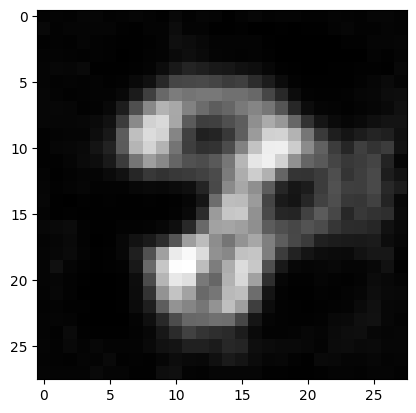

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define a quantum device
dev = qml.device('default.qubit', wires=4)

# Quantum variational circuit
@qml.qnode(dev)
def quantum_circuit(params, x):
    # Apply quantum gates to represent data
    qml.BasisState(x, wires=[0, 1, 2, 3])

    # Apply a variational ansatz
    qml.RX(params[0], wires=0)
    qml.RX(params[1], wires=1)
    qml.RX(params[2], wires=2)
    qml.RX(params[3], wires=3)

    # Measure in the computational basis
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(4)]

# Define the classical neural network (for VAE)
class ClassicalVAE(nn.Module):
    def __init__(self):
        super(ClassicalVAE, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 400)  # Input image size for MNIST
        self.fc21 = nn.Linear(400, 20)  # Mean for latent space
        self.fc22 = nn.Linear(400, 20)  # Log variance for latent space
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 28 * 28)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x.view(-1, 28 * 28)))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function: Negative ELBO
def loss_function(recon_x, x, mu, logvar):
    # Denormalize the input x to be between 0 and 1
    x_denorm = (x * 0.5) + 0.5
    BCE = nn.functional.binary_cross_entropy(recon_x, x_denorm.view(-1, 28 * 28), reduction='sum')
    # Use quantum-enhanced KL divergence (approximated here)
    Q_KL = torch.mean(mu**2 + torch.exp(logvar) - logvar - 1)
    return BCE + Q_KL

# Training loop for Quantum VAE
def train_model(model, data_loader, epochs=5):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_idx, (data, _) in enumerate(data_loader):
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        print(f"Epoch {epoch + 1}, Average loss: {train_loss / len(data_loader.dataset)}")

# Loading the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_data = datasets.MNIST('~/.pytorch_datasets', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

# Instantiate model and train
vae_model = ClassicalVAE()
train_model(vae_model, train_loader)

# Test the trained model on a sample
sample_data = torch.randn(1, 20)  # Random latent space sample
output_image = vae_model.decode(sample_data)
plt.imshow(output_image.view(28, 28).detach().numpy(), cmap="gray")
plt.show()
